In [22]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap.umap_ import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import pearsonr
import itertools
import os,sys 
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)  
sys.path.append(project_root)

from configs.dreamachine2 import config
from src.preprocessor import preproc

EMBEDDING_MODEL_NAME = config.transformer_model
print(f"Transformer model: {EMBEDDING_MODEL_NAME}")

dataset = "DREAMACHINE"
sentences = True

condition = "DL"  # Change to "DL" for the other dataset
NUM_RUNS = 2

print(f"Current working directory: {os.getcwd()}")
BOX_DIR = os.path.join(os.path.expanduser("~"), "Library", "CloudStorage", "Box-Box", "TMDATA")
print(f"Retrieving data from BOX, locally stored at: {BOX_DIR}")
DATA_DIR = os.path.join(BOX_DIR, dataset)
print(f"Data directory: {DATA_DIR}")
results_dir = os.path.join(project_root, "EVAL",dataset.lower())

reports_path = os.path.join(DATA_DIR, f"{condition}_reflections_APIcleaned.csv")
print("Using data from:", reports_path)

# load data and divide into sentences if needed
df_reports = pd.read_csv(reports_path)['cleaned_reflection'].dropna().reset_index(drop=True)
df_reports

#preproc reports using preproc function in src
df_reports = preproc(df_reports)
print(f"Loaded and preprocessed {len(df_reports)} sentences for condition '{condition}'.")

Transformer model: Qwen/Qwen3-Embedding-0.6B
Current working directory: /Users/rb666/Projects/MOSAIC/EVAL
Retrieving data from BOX, locally stored at: /Users/rb666/Library/CloudStorage/Box-Box/TMDATA
Data directory: /Users/rb666/Library/CloudStorage/Box-Box/TMDATA/DREAMACHINE
Using data from: /Users/rb666/Library/CloudStorage/Box-Box/TMDATA/DREAMACHINE/DL_reflections_APIcleaned.csv

Successfully loaded and processed 205 sentences.
After removing short sentences, 198 sentences remain.
After removing duplicates, 198 remain.
Loaded and preprocessed 198 sentences for condition 'DL'.


In [23]:
### Chose either to load best params from grid search, optuna or use defaults tailored ones from the config file

param_selection = "optuna" #can be "optuna", "default", or "grid_search"
target_trial_number = None #item nb of a specific trial, or None to load the best one
sanitized_model_name = config.transformer_model.replace('/', '_') #name of the transformer model with '/' replaced by '_'


if param_selection=="optuna":
    if target_trial_number is None:
        params = pd.read_csv(os.path.join(results_dir,f"OPTUNA_results_{condition}_{'sentences' if sentences else ''}_{sanitized_model_name}.csv")).sort_values(by='embedding_coherence', ascending=False).reset_index(drop=True)
        chosen_params = params.iloc[0]
        print("Best parameters loaded from optuna:")
        print(chosen_params)
    else:
        params = pd.read_csv(os.path.join(results_dir,f"OPTUNA_results_{condition}_{'sentences' if sentences else ''}_{sanitized_model_name}.csv"))
        chosen_params_row = params[params['trial_number'] == target_trial_number]
        # Check if the trial was actually found in the file
        if not chosen_params_row.empty:
            # .iloc[0] selects the first row of the filtered result, which gives us the parameter series
            chosen_params = chosen_params_row.iloc[0]
            print(f"Parameters successfully loaded for Optuna trial number: {target_trial_number}")
            print(chosen_params)
        else:
            raise ValueError(f"Error: Trial number {target_trial_number} was not found in the results file.")

elif param_selection=="grid_search":
    params = pd.read_csv(os.path.join(results_dir,f"GS_results_{condition}_{'sentences' if sentences else ''}.csv")).sort_values(by='embedding_coherence', ascending=False).reset_index(drop=True)
    chosen_params = params.iloc[0]
    print("Best parameters loaded from grid search:")
    print(chosen_params)
elif param_selection=="default":
    print(f"Loading default parameters for condition: {condition}")
    chosen_params = config.get_default_params(condition)
    print("Default parameters loaded:")
    print(pd.Series(chosen_params))
else:
    raise ValueError("param_selection must be 'optuna', 'default', or 'grid_search'")


Best parameters loaded from optuna:
trial_number             92.000000
embedding_coherence       0.560545
n_components              7.000000
n_neighbors               8.000000
min_dist                  0.040000
min_cluster_size         10.000000
min_samples               9.000000
coherence_score           0.509148
coherence_score_umass   -17.678234
n_topics                  8.000000
Name: 0, dtype: float64


In [ ]:


#  BERTopic model components 
embedding_model = SentenceTransformer(EMBEDDING_MODEL_NAME)

vectorizer_model = CountVectorizer(
    ngram_range=config.ngram_range, 
    stop_words=list(config.extended_stop_words),
    max_df=config.max_df,
    min_df=config.min_df
)

# analysis loop
all_topic_freqs = []
print(f"\nStarting {NUM_RUNS} analysis runs...")

print("Pre-computing sentence embeddings...")
embeddings = embedding_model.encode(df_reports, show_progress_bar=True)

for i in range(NUM_RUNS):
    # use a different random_state for each run to ensure different initialisations
    random_seed = i

    umap_model_seeded = UMAP(
        n_neighbors=int(chosen_params['n_neighbors']),
        n_components=int(chosen_params['n_components']),
        min_dist=float(chosen_params['min_dist']),
        random_state=random_seed,
        metric='cosine'
    )

    hdbscan_model = HDBSCAN(
    min_cluster_size=int(chosen_params['min_cluster_size']),
    min_samples=int(chosen_params['min_samples']) if pd.notna(chosen_params['min_samples']) else None)

    topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model_seeded,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        top_n_words= config.top_n_words,
        nr_topics="auto",
        verbose=False
    )

    topics, _ = topic_model.fit_transform(df_reports, embeddings)

    freq = topic_model.get_topic_info()
    freq = freq[freq.Topic != -1]
    all_topic_freqs.append(freq)
    print(f"Run {i+1}/{NUM_RUNS} complete. Found {len(freq)} topics.")

# correlation calculation 
correlations = []

# compare every pair of runs
for (i, j) in itertools.combinations(range(NUM_RUNS), 2):
    freq1 = all_topic_freqs[i]
    freq2 = all_topic_freqs[j]

    # get the sorted list of topic counts for each run
    counts1 = freq1['Count'].sort_values(ascending=False).values
    counts2 = freq2['Count'].sort_values(ascending=False).values

    # pad the shorter list with zeros to make them equal length
    len1, len2 = len(counts1), len(counts2)
    if len1 > len2:
        counts2 = np.pad(counts2, (0, len1 - len2), 'constant')
    elif len2 > len1:
        counts1 = np.pad(counts1, (0, len2 - len1), 'constant')

    # calculate Pearson correlation for the frequency distributions
    if len(counts1) > 1 and len(counts2) > 1: # Pearson r requires at least 2 data points
        r, _ = pearsonr(counts1, counts2)
        correlations.append(r)

# final results 
if correlations:
    mean_correlation = np.mean(correlations)
    std_dev_correlation = np.std(correlations)

    print("\n--- Reproducibility Results ---")
    print(f"Mean Pearson Correlation (r) across {len(correlations)} pairs of runs: {mean_correlation:.4f}")
    print(f"Standard Deviation of Correlation: {std_dev_correlation:.4f}")

    print("\nText for reviewer response:")
    print(f"(mean Pearson correlation r = {mean_correlation:.2f} ± {std_dev_correlation:.2f})")
else:
    print("\nCould not calculate correlations. This might happen if models consistently produced 0 or 1 topic.")


Starting 2 analysis runs...
Pre-computing sentence embeddings...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

AttributeError: 'numpy.ndarray' object has no attribute 'get_topic_info'

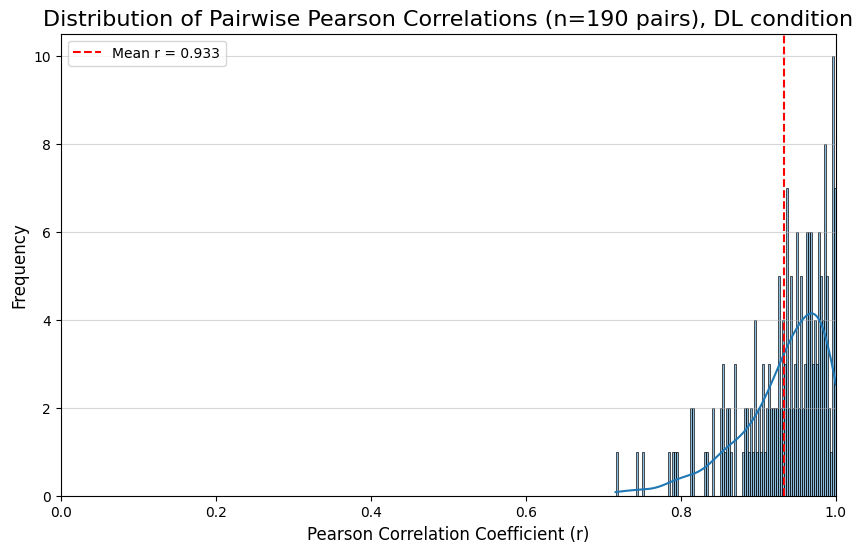

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt


if correlations:

    plt.figure(figsize=(10, 6))
    sns.histplot(correlations, bins=110, kde=True)
    
    plt.title(f'Distribution of Pairwise Pearson Correlations (n={len(correlations)} pairs), {condition} condition', fontsize=16)
    plt.xlabel('Pearson Correlation Coefficient (r)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xlim(0, 1) # Set x-axis from 0 to 1 for correlation
    
    plt.axvline(mean_correlation, color='r', linestyle='--', label=f'Mean r = {mean_correlation:.3f}')
    
    plt.legend()
    plt.grid(axis='y', alpha=0.5)
    
    plt.savefig(f'{condition}_correlation_histogram.png', dpi=300)
    plt.show()

Running BERTopic with random_state = 1...
Running BERTopic with random_state = 2...
Generating 2D UMAP projection for visualization...


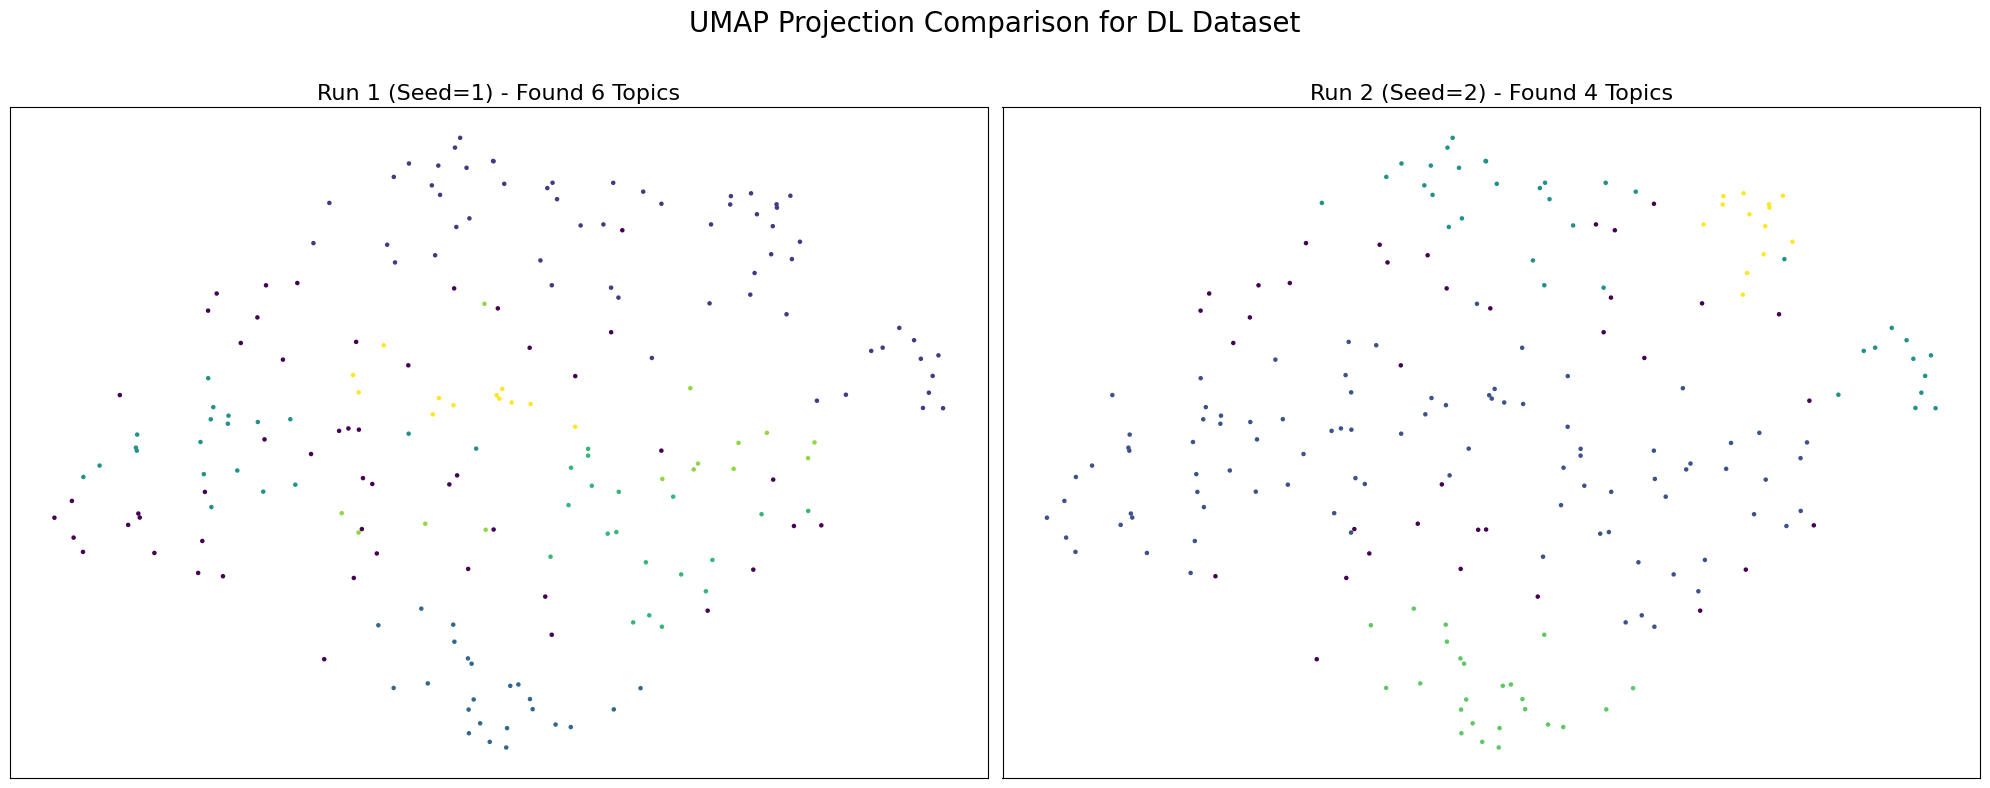

In [25]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from bertopic import BERTopic
# from sentence_transformers import SentenceTransformer
# from umap import UMAP
# from hdbscan import HDBSCAN
# from sklearn.feature_extraction.text import CountVectorizer
# import os
# import sys

# # --- 1. Configuration (Same as your script) ---
# # Ensure paths and config imports are correct
# current_dir = os.getcwd()
# project_root = os.path.dirname(current_dir)
# sys.path.append(project_root)

# from configs.dreamachine2 import config
# from src.preprocessor import preproc

# EMBEDDING_MODEL_NAME = config.transformer_model
# CONDITION = "DL"  # Change to "HS" if needed
# DATASET = "DREAMACHINE"

# # --- 2. Load Data and Parameters (Same as your script) ---
# reports_path = f"path/to/your/data/{CONDITION}_reflections_APIcleaned.csv" # UPDATE THIS PATH
# df_reports = pd.read_csv(reports_path)['cleaned_reflection'].dropna().reset_index(drop=True)
# sentences = preproc(df_reports)

# params_path = f"path/to/your/EVAL/{DATASET.lower()}/OPTUNA_results_{CONDITION}_sentences_{EMBEDDING_MODEL_NAME.replace('/', '_')}.csv" # UPDATE THIS PATH
# params = pd.read_csv(params_path).sort_values(by='embedding_coherence', ascending=False).reset_index(drop=True)
# chosen_params = params.iloc[0]

# # --- 3. BERTopic and Embedding Setup (Same as your script) ---
# embedding_model = SentenceTransformer(EMBEDDING_MODEL_NAME)
# vectorizer_model = CountVectorizer(ngram_range=config.ngram_range, stop_words="english")
# embeddings = embedding_model.encode(sentences, show_progress_bar=True)

# --- 4. Helper Function to Run BERTopic for a specific seed ---
def run_bertopic_for_seed(seed):
    """Runs the BERTopic pipeline for a given seed and returns the model and topics."""
    print(f"Running BERTopic with random_state = {seed}...")
    
    umap_model_seeded = UMAP(
        n_neighbors=int(chosen_params['n_neighbors']),
        n_components=int(chosen_params['n_components']),
        min_dist=float(chosen_params['min_dist']),
        random_state=seed,
        metric='cosine'
    )
    hdbscan_model = HDBSCAN(
        min_cluster_size=int(chosen_params['min_cluster_size']),
        min_samples=int(chosen_params['min_samples']) if pd.notna(chosen_params['min_samples']) else None
    )
    topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model_seeded,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        top_n_words= config.top_n_words,
        nr_topics="auto",
        verbose=False
    )
    topics, _ = topic_model.fit_transform(df_reports, embeddings)
    return topic_model, topics


# --- 5. Run for Two Different Seeds ---
topic_model_1, topics_1 = run_bertopic_for_seed(seed=1)
topic_model_2, topics_2 = run_bertopic_for_seed(seed=2)

# --- 6. Create a consistent 2D Projection for Visualization ---
print("Generating 2D UMAP projection for visualization...")
umap_2d_model = UMAP(n_components=2, random_state=42, metric='cosine')
embeddings_2d = umap_2d_model.fit_transform(embeddings)

# --- 7. Plotting the Side-by-Side Comparison ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle(f'UMAP Projection Comparison for {condition} Dataset', fontsize=20)

# Plot for Run 1
axes[0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=topics_1, s=5, cmap='viridis')
axes[0].set_title(f'Run 1 (Seed=1) - Found {len(topic_model_1.get_topic_info())-1} Topics', fontsize=16)
axes[0].set_xticks([])
axes[0].set_yticks([])

# Plot for Run 2
axes[1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=topics_2, s=5, cmap='viridis')
axes[1].set_title(f'Run 2 (Seed=2) - Found {len(topic_model_2.get_topic_info())-1} Topics', fontsize=16)
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f'supplementary_figure_{condition}_umap_comparison.png', dpi=300)
plt.show()